In [1]:
import warnings; warnings.simplefilter('ignore')

import sys
sys.path.insert(0, '/home/jcbyts/Repos/')

import Utils as U
import gratings as gt

import NDN3.NDNutils as NDNutils

which_gpu = NDNutils.assign_gpu()

import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

from scipy.ndimage import gaussian_filter
from copy import deepcopy

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt  # plotting
import seaborn as sns

import NDN3.NDN as NDN
import NDN3.Utils.DanUtils as DU

*******************************************************************************************
---> getting list of available GPUs:
[0, 1]

---> getting GPU memory map:
{0: 270, 1: 489}

---> setting up GPU with largest available memory:
   ...picking GPU # 0
*******************************************************************************************

Done!


In [2]:
from scipy.io import loadmat

opts = loadmat('testdata.mat')

stim = opts['stim']
sacon = opts['sacon'].T
sacoff = opts['sacoff'].T
basis = opts['basis']
Robs = opts['Robs']
RobsAll = Robs.copy()
sacbc = opts['sacbc']
valid = opts['valid']
eyepos = opts['eyepos']
# gotta clean up for the borked way loadmat works
opts['NX'] = opts['NX'][0][0]
opts['NY'] = opts['NY'][0][0]
opts['Ui'] = opts['Ui'][0]
opts['Xi'] = opts['Xi'][0]
opts['Ti'] = opts['Ti'][0]
# opts['num_repeats'] = opts['num_repeats'][0][0]

Ui = opts['Ui']
Xi = opts['Xi']
Ti = opts['Ti']

Text(0, 0.5, 'd.v.a')

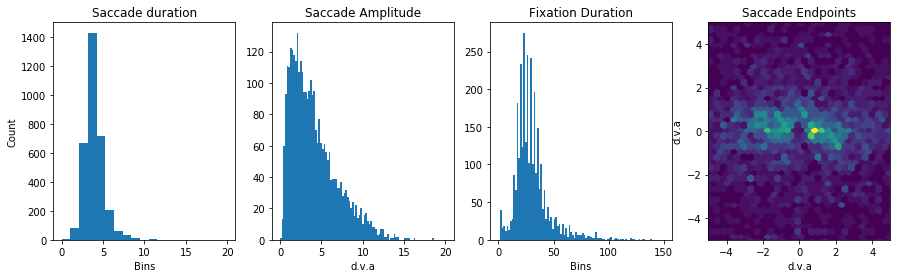

In [3]:
# plot raw data
ixon = np.where(np.diff(sacbc, axis=0)==1)[0]
ixoff = np.where(np.diff(sacbc, axis=0)==-1)[0]

# saccade endpoints
dx = eyepos[ixoff,1]-eyepos[ixon,1]
dy = eyepos[ixoff,2]-eyepos[ixon,2]

# saccade Amplitude
sacAmp = np.hypot(dx, dy)
sacAmp[np.isnan(sacAmp)] = 0

plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
f = plt.hist(ixoff-ixon, bins=np.linspace(0, 20,20))
plt.xlabel('Bins')
plt.ylabel('Count')
plt.title('Saccade duration')

plt.subplot(1,4,2)
f = plt.hist(sacAmp, bins=np.linspace(0, 20,100))
plt.xlabel('d.v.a')
plt.title('Saccade Amplitude')

plt.subplot(1,4,3)
f = plt.hist(ixon[1:]-ixoff[:-1], bins=np.linspace(0, 150,100))
plt.xlabel('Bins')
plt.title('Fixation Duration')

plt.subplot(1,4,4)
f = plt.hexbin(dx, dy,gridsize=100)
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.title('Saccade Endpoints')
plt.xlabel('d.v.a')
plt.ylabel('d.v.a')


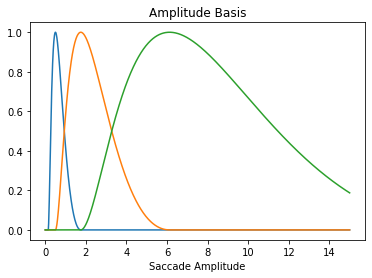

In [4]:
# if you want to do the saccade amplitude basis
# project saccade size on a tent basis
nSacBasis = 3
bax = np.linspace(0,15,1000)
# sB = gt.tent_basis_log(bax,nSacBasis,0.5,2.5)
sB = gt.raised_cosine(bax,nSacBasis,0.5,3.5)
plt.plot(bax, sB)
plt.xlabel("Saccade Amplitude")
plt.title('Amplitude Basis')
sacOnAmp = sacon.copy()
sacOnAmp[ixon,0] = sacAmp
sacOnAmp = gt.raised_cosine(sacOnAmp.flatten(),nSacBasis,0.5,3.5)

sacOffAmp = sacoff.copy()
sacOffAmp[ixoff,0] = sacAmp
sacOffAmp = gt.raised_cosine(sacOffAmp.flatten(), nSacBasis, 0.5, 3.5)

back_shiftson = 40
back_shiftsoff = 2
sacOnAmpshift = NDNutils.shift_mat_zpad(sacOnAmp,-back_shiftson,dim=0)
sacOffAmpshift = NDNutils.shift_mat_zpad(sacOffAmp,-back_shiftsoff,dim=0)



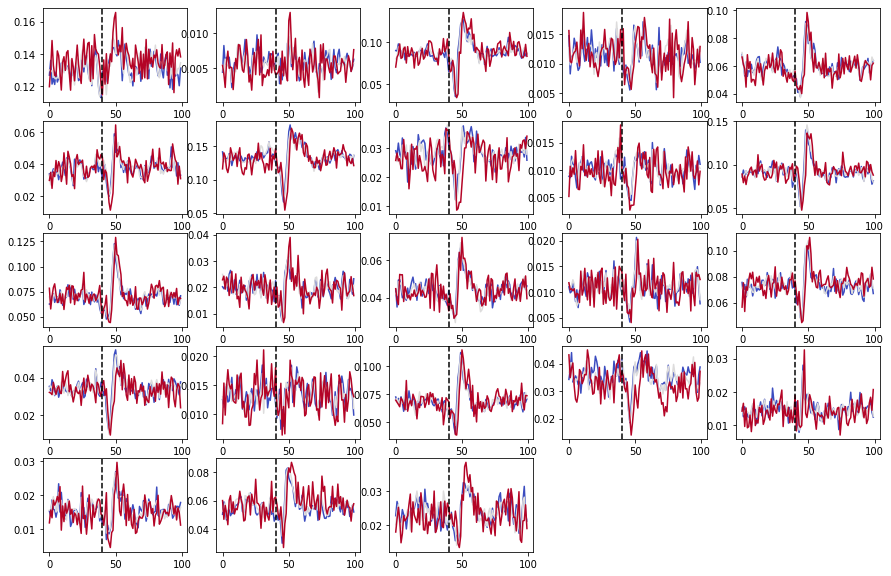

In [30]:
# plot the saccade-triggered firing rate 
nlags = 100

# use sacAmpshift to see if there's modulation / size selectivity
Xsacon = NDNutils.create_time_embedding( sacOnAmpshift, [nlags, 1, nSacBasis], tent_spacing=1)

NC = Robs.shape[1]
cm = plt.cm

sx,sy = U.get_subplot_dims(NC)
plt.figure(figsize=(15,10))

cm = plt.cm.coolwarm(np.linspace(0, 1, nSacBasis))

for cc in range(NC):
    
    rmult = np.expand_dims(Robs[:,cc], axis=1)*Xsacon
    
    sacta = np.sum(rmult[Ui,:], axis=0)/np.sum(Xsacon[Ui,:], axis=0)
    sacta = np.reshape(sacta, (nSacBasis, nlags)).T
    plt.subplot(sx,sy,cc+1)
    for i in range(nSacBasis):
        plt.plot(sacta[:,i], color=cm[i])

    plt.axvline(x=back_shiftson,color='k',linestyle='--')


### Use size tuning to capture duration effects

In [5]:
# optimizer parameters
adam_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True}, learning_alg='adam')

early_stopping = 100

adam_params['batch_size'] = 1000
adam_params['display'] = 30
adam_params['MAPest'] = True
adam_params['epochs_training'] = 1000
adam_params['early_stop'] = early_stopping
adam_params['early_stop_mode'] = 1
adam_params['epsilon'] = 1e-8
adam_params['data_pipe_type'] = 'data_as_var' # 'feed_dict'
adam_params['learning_rate'] = 1e-3

lbfgs_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True, 'display': True}, learning_alg='lbfgs')
lbfgs_params['maxiter'] = 10000

In [6]:
# fit stimulus model and remove bad units
num_tkerns = 3
num_lags = 15
seed = 5
NX = opts['NX']
NY = opts['NY']
NC = RobsAll.shape[1]

glm_par = NDNutils.ffnetwork_params(
    input_dims=[1,NX,NY], time_expand=[num_lags],
    layer_sizes=[num_tkerns, NC],
    layer_types=['temporal', 'normal'], # readout for cell-specific regularization
    act_funcs=['lin', 'softplus'],
    normalization=[1, 0],
    reg_list={'orth':[1e-2],'d2t': [1e-5], 'd2x': [None,1e-5], 'l2':[1e-6,1e-6]}
)

glm = NDN.NDN([glm_par], tf_seed=seed, noise_dist='poisson')

_ = glm.train(input_data=[stim], output_data=RobsAll, train_indxs=Ui, test_indxs=Xi,
    learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

print("Done Training Initial Model")

LLx0 = glm.eval_models(input_data=[stim], output_data=RobsAll, data_indxs=Xi, nulladjusted=True)

cids = LLx0>0.01
print("%d/%d units better than null model" %(np.sum(cids), len(LLx0)))
Robs = RobsAll[:,cids].copy()

W0513 09:22:35.443596 140274042554176 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:262: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0513 09:22:35.445102 140274042554176 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:270: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

W0513 09:22:35.446012 140274042554176 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:273: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0513 09:22:35.446846 140274042554176 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:1085: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0513 09:22:35.456175 140274042554176 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/layer.py:236: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead

Input dimensions: [1, 8, 7]
0: temporal (lin):  	[E3/I0] N
1: normal (softplus):  	[E30/I0] 


W0513 09:22:35.834025 140274042554176 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0513 09:22:35.896058 140274042554176 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0513 09:22:35.943171 140274042554176 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:336: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0513 09:22:35.95

Done Training Initial Model
17/30 units better than null model


In [7]:
## Fit GLM stimulus model (good units only)
NT,NC=Robs.shape
print("%d Time points, %d Neurons" %(NT, NC))

glm_par = NDNutils.ffnetwork_params(
    input_dims=[1,NX,NY], time_expand=[num_lags],
    layer_sizes=[num_tkerns, NC],
    layer_types=['temporal', 'normal'], # readout for cell-specific regularization
    act_funcs=['lin', 'softplus'],
    normalization=[1, 0],
    reg_list={'orth':[1e-3],'d2t': [1e-5], 'd2x': [None,1e-4], 'l2':[1e-6,1e-6]}
)

glm = NDN.NDN([glm_par], tf_seed=seed, noise_dist='poisson')

_ = glm.train(input_data=[stim], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
    learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

print("Done Training Initial Model")

LLx0 = glm.eval_models(input_data=[stim], output_data=Robs, data_indxs=Xi, nulladjusted=True)


112800 Time points, 17 Neurons
Input dimensions: [1, 8, 7]
0: temporal (lin):  	[E3/I0] N
1: normal (softplus):  	[E17/I0] 
Done Training Initial Model


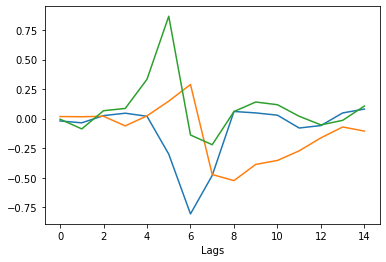

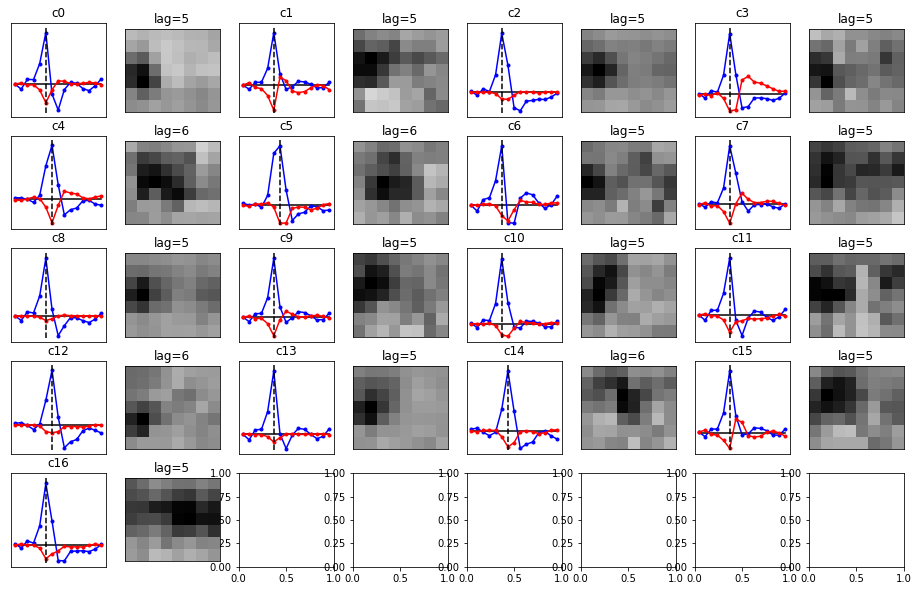

In [8]:
plt.figure()
plt.plot(glm.networks[0].layers[0].weights)
plt.xlabel("Lags")

DU.plot_3dfilters(glm)

In [33]:
# build saccade inputs
num_onlags = 80
back_shiftson = 40

tspacing = list(np.concatenate([np.arange(0,20,5), np.arange(20,40,3), np.arange(40,50,2), np.arange(50,num_onlags,5)]))

saconshift = NDNutils.shift_mat_zpad(sacon,-back_shiftson,dim=0)

sacOnAmpshift = NDNutils.shift_mat_zpad(sacOnAmp,-back_shiftson,dim=0)

print("%d nans found" %(np.sum(np.isnan(sacOnAmpshift))))


0 nans found


Input dimensions: [1, 1, 3]
0: temporal (lin):  	[E2/I0] N
1: normal (lin):  	[E3/I0] N
2: normal (lin):  	[E17/I0] 
0: add (softplus):  	[E17/I0] 
  Temporal layer: must expand temporal basis from 76 to 80.
  Temporal layer: updating number of weights in temporal layer from 80 to 22.


Text(0.5, 1.0, 'Sac Onset Basis')

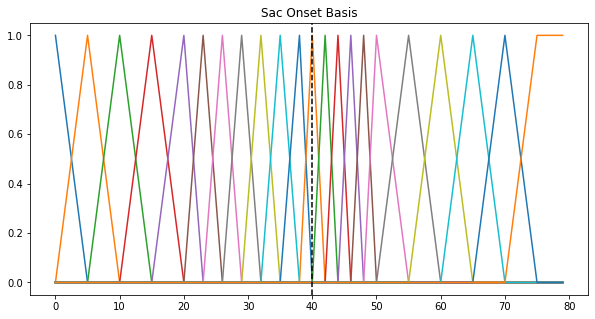

In [34]:
# saccade modulation model is shared
num_sacsubs = 3
num_sactkerns = 2

stim_par = glm_par.copy()  # copy the stimulus parameters from the GLM
stim_par['activation_funcs'][-1] = 'lin' # switch to linear activation, softplus will still be on the output

sac_on_par = NDNutils.ffnetwork_params(
    input_dims=[1,1,nSacBasis],
    time_expand=[num_onlags],
    xstim_n=[1],
    layer_sizes=[num_sactkerns, num_sacsubs, NC], # conv_filter_widths=[1],
    layer_types=['temporal', 'normal', 'normal'],
    act_funcs=['lin', 'lin', 'lin'],
    normalization=[1, 1, 0],
    reg_list={'orth':[None], 'd2t':[1e-1], 'd2x':[None, None]})


comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[0,1], layer_sizes=[NC],
    layer_types=['add'], act_funcs=['softplus'])

# initialize NDN
ndn2 = NDN.NDN([stim_par, sac_on_par, comb_par], noise_dist='poisson')
ndn2.networks[1].layers[0].init_temporal_basis( xs=tspacing )

# stimulus is the same
ndn2.networks[0].layers[0].weights = deepcopy(glm.networks[0].layers[0].weights)
ndn2.networks[0].layers[1].weights = deepcopy(glm.networks[0].layers[1].weights)
ndn2.networks[0].layers[1].biases = deepcopy(glm.networks[0].layers[1].biases)

# add network has 0 bias and weights 1
ndn2.networks[2].layers[0].weights /= ndn2.networks[2].layers[0].weights

plt.figure(figsize=(10,5))
f = plt.plot(ndn2.networks[1].layers[0].filter_basis)
plt.axvline(back_shiftson, color='k', linestyle='--')
plt.title("Sac Onset Basis")

In [35]:
# Train
v2f0 = ndn2.fit_variables(layers_to_skip=[[0,1], [], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn2.train(input_data=[stim, sacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

print("Done training additive saccade model")

Done training additive saccade model


In [36]:
# Refit all variables
v2f0 = ndn2.fit_variables(layers_to_skip=[[0], [], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn2.train(input_data=[stim, sacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg='lbfgs', opt_params=lbfgs_params, use_dropout=False)

print("Done training additive saccade model")

Done training additive saccade model


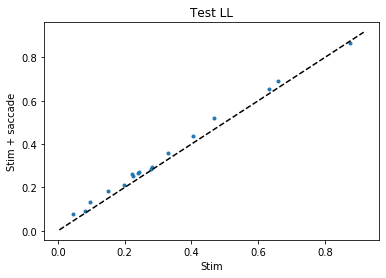

In [37]:
glm.time_spread=ndn2.time_spread
LLx0 = glm.eval_models(input_data=[stim],output_data=Robs, data_indxs=Xi, nulladjusted=True)
LLx1 = ndn2.eval_models(input_data=[stim, sacOnAmpshift], output_data=Robs, data_indxs=Xi, nulladjusted=True)

plt.plot(LLx0, LLx1, '.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')
plt.title('Test LL')
plt.xlabel('Stim')
plt.ylabel('Stim + saccade')

Rpred0 = glm.generate_prediction(input_data=[stim])
Rpred1 = ndn2.generate_prediction(input_data=[stim, sacOnAmpshift])

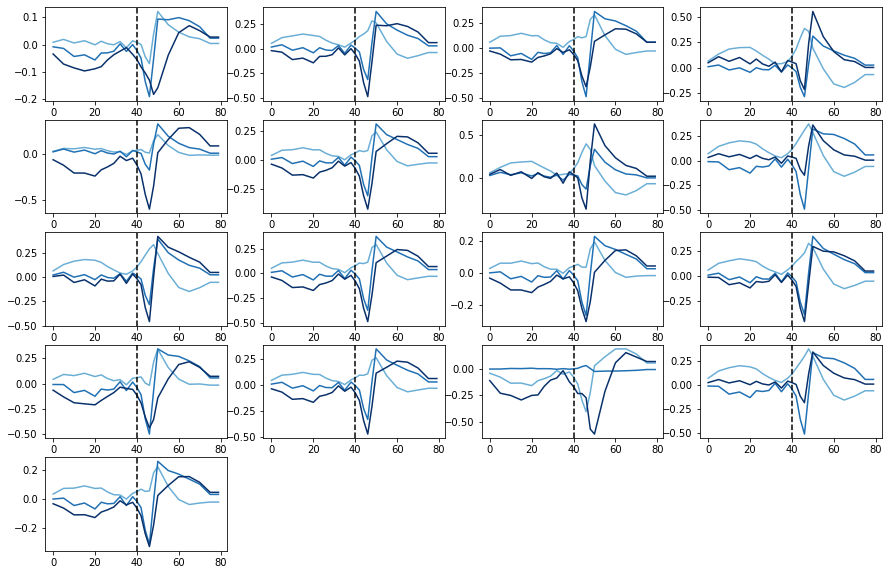

In [38]:
# plot kernels
ndn_mod = ndn2.copy_model()
ffnet = 1
# filters = DU.compute_spatiotemporal_filters(ndn_mod, ffnet=ffnet) # not working??

ks_flat = DU.tbasis_recover_filters(ndn_mod, ffnet=ffnet)

w = ks_flat@ndn_mod.networks[ffnet].layers[2].weights

w = np.reshape(w, (nSacBasis, -1, NC))
w.shape

cm = plt.cm.Blues(np.linspace(0.5, 1, nSacBasis))
plt.figure(figsize=(15,10))
sx,sy = U.get_subplot_dims(NC)
for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
    for i in range(nSacBasis):
        plt.plot(w[i,:,cc], color=cm[i])
    plt.axvline(back_shiftson, color='k', linestyle='--')
        

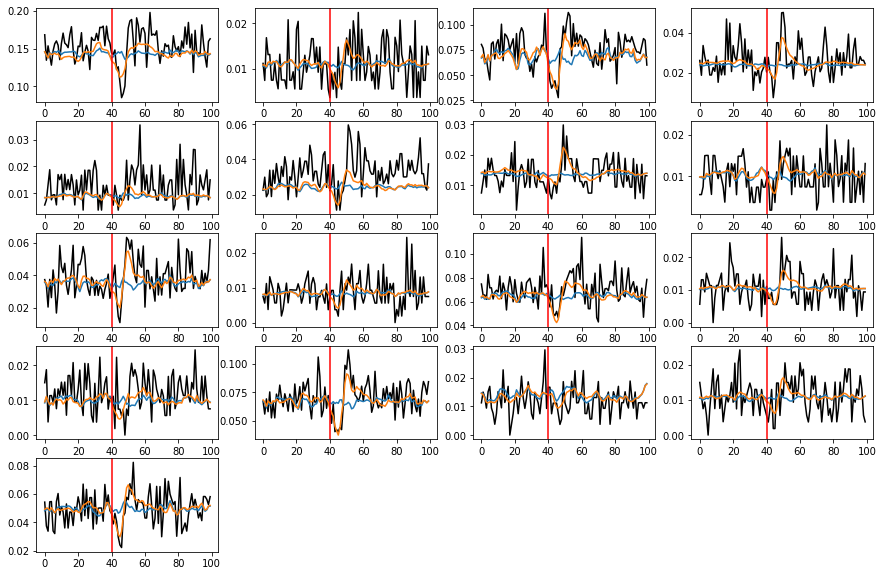

In [39]:
# plot the saccade-triggered firing rate 
nlags = 100

# use sacAmpshift to see if there's modulation / size selectivity
Xsacon = NDNutils.create_time_embedding( saconshift, [nlags, 1, 1], tent_spacing=1)

NC = Robs.shape[1]
cm = plt.cm

sx,sy = U.get_subplot_dims(NC)
plt.figure(figsize=(15,10))

r2glm = []
r2sac = []
for cc in range(NC):
    
    rmult = np.expand_dims(Robs[:,cc], axis=1)*Xsacon # Data
    rmult0 = np.expand_dims(Rpred0[:,cc], axis=1)*Xsacon # GLM
    rmult1 = np.expand_dims(Rpred1[:,cc], axis=1)*Xsacon # GLM + Saccade Modulation
    
    sactaData = np.sum(rmult[Xi,:], axis=0)/np.sum(Xsacon[Xi,:], axis=0)
    sacta0 = np.sum(rmult0[Xi,:], axis=0)/np.sum(Xsacon[Xi,:], axis=0)
    sacta1 = np.sum(rmult1[Xi,:], axis=0)/np.sum(Xsacon[Xi,:], axis=0)

    plt.subplot(sx,sy,cc+1)
    plt.plot(sactaData, color='k')
    plt.plot(sacta0)
    plt.plot(sacta1)
    
    sactaData = np.expand_dims(sactaData, axis=1)
    sacta0 = np.expand_dims(sacta0, axis=1)
    sacta1 = np.expand_dims(sacta1, axis=1)
    
    r2glm.append(U.r_squared(sactaData, sacta0))
    r2sac.append(U.r_squared(sactaData, sacta1))

    plt.axvline(x=back_shiftson,color='r')
    

Text(0, 0.5, 'Stim + sac')

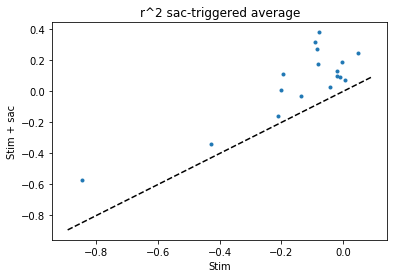

In [40]:
plt.plot(np.asarray(r2glm), np.asarray(r2sac), '.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')
plt.title('r^2 sac-triggered average')
plt.xlabel('Stim')
plt.ylabel('Stim + sac')

## Try adding the saccade during parameter as a gain


In [49]:
# the model will have 6 FF networks
# 0: stimulus
# 1: saccade onset
# 2: saccade offset
# 3: saccade during
# 4: mult (0,3)
# 5: add (0,1,2,4)

sac_on_par = NDNutils.ffnetwork_params(
    input_dims=[1,1,nSacBasis],
    time_expand=[num_onlags],
    xstim_n=[1],
    layer_sizes=[num_sactkerns, num_sacsubs, NC], # conv_filter_widths=[1],
    layer_types=['temporal', 'normal', 'normal'],
    act_funcs=['lin', 'lin', 'lin'],
    normalization=[1, 1, 0],
    reg_list={'orth':[None], 'd2t':[1e-1], 'l2':[None, 1e-5, None]})

mult_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[0,2], layer_sizes=[NC],
    layer_types=['mult'], act_funcs=['lin'])

comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[1,3], layer_sizes=[NC],
    layer_types=['add'], act_funcs=['softplus'])

# initialize NDN
ndn3 = NDN.NDN([stim_par, sac_on_par, sac_on_par, mult_par, comb_par], ffnet_out=4, noise_dist='poisson')
ndn3.networks[1].layers[0].init_temporal_basis( xs=tspacing )
ndn3.networks[2].layers[0].init_temporal_basis( xs=tspacing )

# stimulus is the same
ndn3.networks[0].layers[0].weights = deepcopy(ndn2.networks[0].layers[0].weights)
ndn3.networks[0].layers[0].biases = deepcopy(ndn2.networks[0].layers[0].biases)
ndn3.networks[0].layers[1].weights = deepcopy(ndn2.networks[0].layers[1].weights)
ndn3.networks[0].layers[1].biases = deepcopy(ndn2.networks[0].layers[1].biases)

# add network weights 1 and bias copied from ndn2
ndn3.networks[4].layers[0].weights /= ndn3.networks[4].layers[0].weights
ndn3.networks[-1].layers[-1].biases = deepcopy(ndn2.networks[-1].layers[-1].biases)

# mult network has 0 bias and weights 1
ndn3.networks[3].layers[0].weights /= ndn3.networks[3].layers[0].weights


# ndn3.networks[2].layers[0].weights *= 0 #deepcopy(ndn2.networks[1].layers[0].weights)
# ndn3.networks[2].layers[1].weights *= 0 #deepcopy(ndn2.networks[1].layers[1].weights)
ndn3.networks[2].layers[2].weights = deepcopy(ndn2.networks[1].layers[2].weights)


Input dimensions: [1, 1, 3]
0: temporal (lin):  	[E2/I0] N
1: normal (lin):  	[E3/I0] N
2: normal (lin):  	[E17/I0] 
Input dimensions: [1, 1, 3]
0: temporal (lin):  	[E2/I0] N
1: normal (lin):  	[E3/I0] N
2: normal (lin):  	[E17/I0] 
0: mult (lin):  	[E17/I0] 
0: add (softplus):  	[E17/I0] 
  Temporal layer: must expand temporal basis from 76 to 80.
  Temporal layer: updating number of weights in temporal layer from 80 to 22.
  Temporal layer: must expand temporal basis from 76 to 80.
  Temporal layer: updating number of weights in temporal layer from 80 to 22.


In [42]:

# ONLY run this cell if you want to see what happens if the additive kernels are out of the picture

# take additive kernel out of the picture and train multiplicative kernel
ndn3.networks[1].layers[0].weights *= 0 #deepcopy(ndn2.networks[1].layers[0].weights)
ndn3.networks[1].layers[1].weights *= 0 #deepcopy(ndn2.networks[1].layers[1].weights)

# Train with adam optimizer
v2f0 = ndn3.fit_variables(layers_to_skip=[[0], [0,1,2], [], [0], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn3.train(input_data=[stim, sacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg='adam', opt_params=adam_params, use_dropout=False)

print("Done training gain saccade model")

Epoch 0000:  avg train cost =    54.8824,  avg test cost =    56.1800,  reg penalty =     0.0755
Epoch 0029:  avg train cost =     5.6183,  avg test cost =     6.0527,  reg penalty =     0.0716
Epoch 0059:  avg train cost =     4.6823,  avg test cost =     5.0375,  reg penalty =     0.0581
Epoch 0089:  avg train cost =     4.4923,  avg test cost =     4.8304,  reg penalty =     0.0419
Epoch 0119:  avg train cost =     4.3743,  avg test cost =     4.6849,  reg penalty =     0.0296
Epoch 0149:  avg train cost =     4.3376,  avg test cost =     4.6379,  reg penalty =     0.0229
Epoch 0179:  avg train cost =     4.3293,  avg test cost =     4.6308,  reg penalty =     0.0200
Epoch 0209:  avg train cost =     4.3286,  avg test cost =     4.6423,  reg penalty =     0.0188
Epoch 0239:  avg train cost =     4.3244,  avg test cost =     4.6321,  reg penalty =     0.0183

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 265,  end cost: 79.147588
     ---> best 

In [50]:
# saccade onset initialized with ndn2
ndn3.networks[1].layers[0].weights = deepcopy(ndn2.networks[1].layers[0].weights)
ndn3.networks[1].layers[1].weights = deepcopy(ndn2.networks[1].layers[1].weights)
ndn3.networks[1].layers[2].weights = deepcopy(ndn2.networks[1].layers[2].weights)

# Train with adam optimizer
v2f0 = ndn3.fit_variables(layers_to_skip=[[0,1], [], [], [0], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn3.train(input_data=[stim, sacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg='adam', opt_params=adam_params, use_dropout=False)

print("Done training gain saccade model")

Epoch 0000:  avg train cost =    38.3418,  avg test cost =    37.6012,  reg penalty =     0.0761
Epoch 0029:  avg train cost =     5.3784,  avg test cost =     5.9610,  reg penalty =     0.0928
Epoch 0059:  avg train cost =     4.6681,  avg test cost =     5.1321,  reg penalty =     0.0769
Epoch 0089:  avg train cost =     4.3935,  avg test cost =     4.7439,  reg penalty =     0.0500
Epoch 0119:  avg train cost =     4.3293,  avg test cost =     4.6202,  reg penalty =     0.0317
Epoch 0149:  avg train cost =     4.3286,  avg test cost =     4.6161,  reg penalty =     0.0228
Epoch 0179:  avg train cost =     4.3278,  avg test cost =     4.6148,  reg penalty =     0.0195
Epoch 0209:  avg train cost =     4.3274,  avg test cost =     4.6243,  reg penalty =     0.0181
Epoch 0239:  avg train cost =     4.3248,  avg test cost =     4.6164,  reg penalty =     0.0174

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 242,  end cost: 79.024226
     ---> best 

In [44]:
v2f0 = ndn3.fit_variables(layers_to_skip=[[0], [], [], [0], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn3.train(input_data=[stim, sacOnAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg='adam', opt_params=adam_params, use_dropout=False)

print("Done training gain saccade model")

Epoch 0000:  avg train cost =     4.3129,  avg test cost =     4.6351,  reg penalty =     0.0187
Epoch 0029:  avg train cost =     4.3132,  avg test cost =     4.6397,  reg penalty =     0.0184
Epoch 0059:  avg train cost =     4.3107,  avg test cost =     4.6352,  reg penalty =     0.0182
Epoch 0089:  avg train cost =     4.3092,  avg test cost =     4.6232,  reg penalty =     0.0181

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 101,  end cost: 78.955799
     ---> best epoch: 51,  best cost: 78.821463

Done training gain saccade model


Text(0, 0.5, 'Stim + saccade on/off/dur')

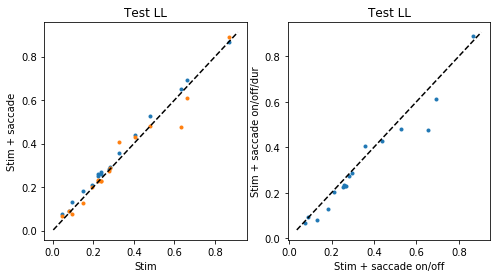

In [45]:
glm.time_spread=ndn3.time_spread
ndn2.time_spread = ndn3.time_spread

LLx0 = glm.eval_models(input_data=[stim],output_data=Robs, data_indxs=Xi, nulladjusted=True)
LLx1 = ndn2.eval_models(input_data=[stim, sacOnAmpshift], output_data=Robs, data_indxs=Xi, nulladjusted=True)
LLx2 = ndn3.eval_models(input_data=[stim, sacOnAmpshift], output_data=Robs, data_indxs=Xi, nulladjusted=True)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(LLx0, LLx1, '.')
plt.plot(LLx0, LLx2, '.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')
plt.title('Test LL')
plt.xlabel('Stim')
plt.ylabel('Stim + saccade')

plt.subplot(122)
plt.plot(LLx1, LLx2, '.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')
plt.title('Test LL')
plt.xlabel('Stim + saccade on/off')
plt.ylabel('Stim + saccade on/off/dur')

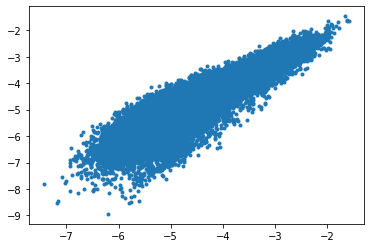

In [46]:
g0 = ndn2.generate_prediction(input_data=[stim, sacOnAmpshift], ffnet_target=0)
g1 = ndn3.generate_prediction(input_data=[stim, sacOnAmpshift], ffnet_target=3)
plt.plot(g0[:,1], g1[:,1], '.')


### Hmm, that didn't work. What happened to the kernels?

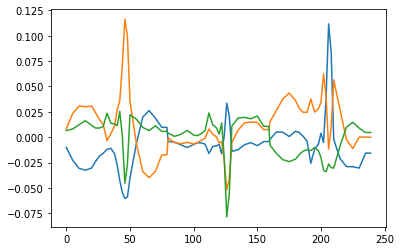

In [48]:



ffnet = 1
ks_flat = DU.tbasis_recover_filters(ndn3, ffnet=ffnet)
plt.plot(ks_flat)

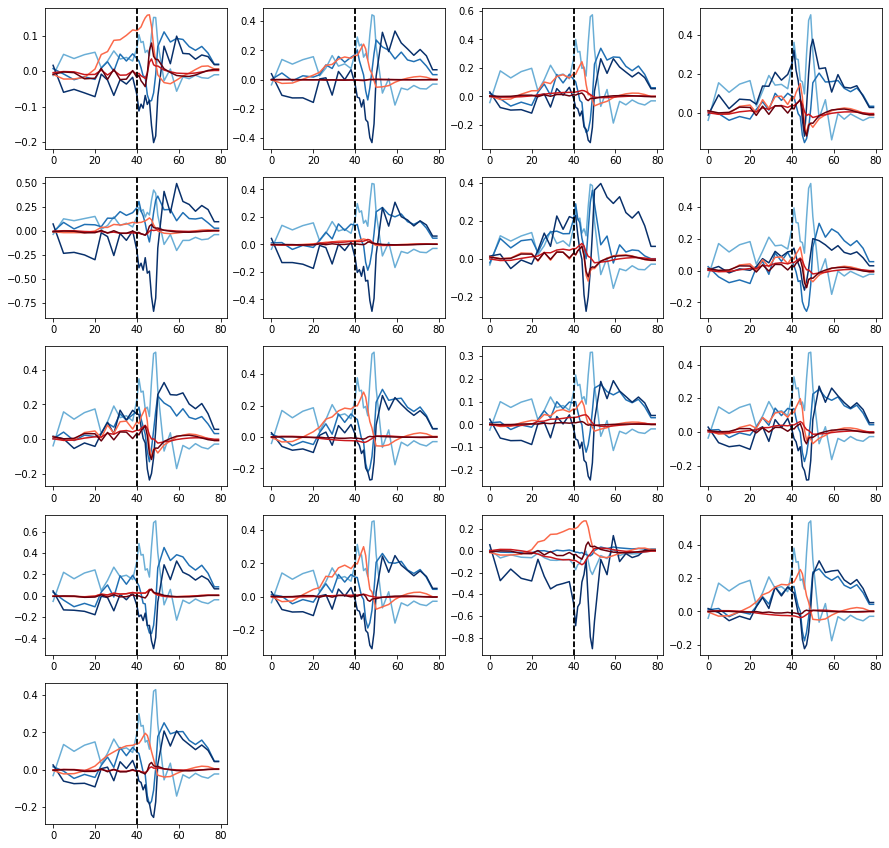

In [24]:
    
    

# def plot_kernel(ndn_mod, ffnet, cm):
#     nSacBasis = len(cm)
#     NC = ndn_mod.output_sizes
    
#     ks_flat = DU.tbasis_recover_filters(ndn_mod, ffnet=ffnet)
#     w = ks_flat@ndn_mod.networks[ffnet].layers[2].weights
plt.figure(figsize=(15,15))
sx,sy = U.get_subplot_dims(NC)

# plot kernels
ndn_mod = ndn3.copy_model()
for ffnet in [1,2]:
    # filters = DU.compute_spatiotemporal_filters(ndn_mod, ffnet=ffnet) # not working??

    ks_flat = DU.tbasis_recover_filters(ndn_mod, ffnet=ffnet)
    w = ks_flat@ndn_mod.networks[ffnet].layers[2].weights

    w = np.reshape(w, (nSacBasis, -1, NC))
    
    if ffnet==1:
        cm = plt.cm.Blues(np.linspace(0.5, 1, nSacBasis))
    else:
        cm = plt.cm.Reds(np.linspace(0.5, 1, nSacBasis))


    for cc in range(NC):
        plt.subplot(sx,sy,cc+1)
        for i in range(nSacBasis):
            plt.plot(w[i,:,cc], color=cm[i])
        plt.axvline(back_shiftson, color='k', linestyle='--')

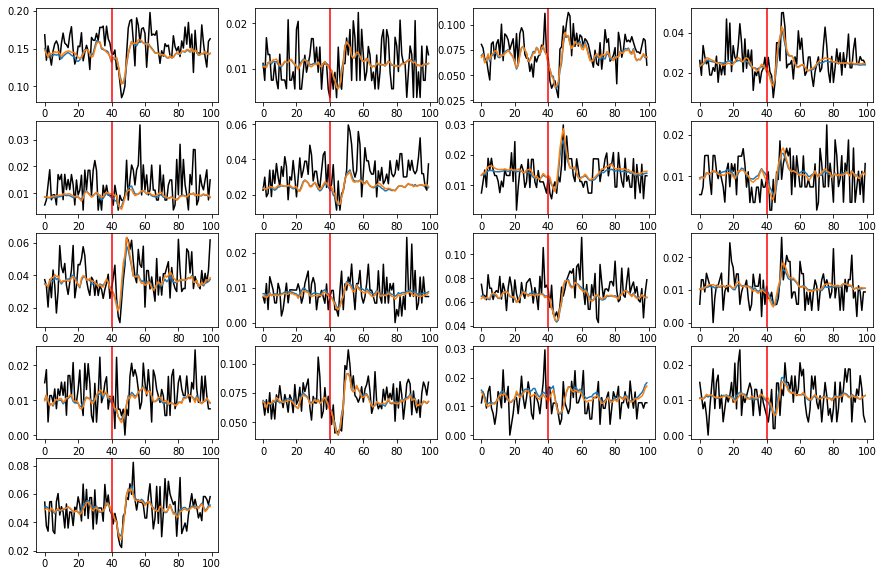

In [25]:
# plot the saccade-triggered firing rate 
nlags = 100
Rpred0 = ndn2.generate_prediction(input_data=[stim, sacOnAmpshift])
Rpred1 = ndn3.generate_prediction(input_data=[stim, sacOnAmpshift])

# use sacAmpshift to see if there's modulation / size selectivity
Xsacon = NDNutils.create_time_embedding( saconshift, [nlags, 1, 1], tent_spacing=1)

NC = Robs.shape[1]
cm = plt.cm

sx,sy = U.get_subplot_dims(NC)
plt.figure(figsize=(15,10))

r2glm = []
r2sac = []
for cc in range(NC):
    
    rmult = np.expand_dims(Robs[:,cc], axis=1)*Xsacon # Data
    rmult0 = np.expand_dims(Rpred0[:,cc], axis=1)*Xsacon # GLM
    rmult1 = np.expand_dims(Rpred1[:,cc], axis=1)*Xsacon # GLM + Saccade Modulation
    
    sactaData = np.sum(rmult[Xi,:], axis=0)/np.sum(Xsacon[Xi,:], axis=0)
    sacta0 = np.sum(rmult0[Xi,:], axis=0)/np.sum(Xsacon[Xi,:], axis=0)
    sacta1 = np.sum(rmult1[Xi,:], axis=0)/np.sum(Xsacon[Xi,:], axis=0)

    plt.subplot(sx,sy,cc+1)
    plt.plot(sactaData, color='k')
    plt.plot(sacta0)
    plt.plot(sacta1)
    
    sactaData = np.expand_dims(sactaData, axis=1)
    sacta0 = np.expand_dims(sacta0, axis=1)
    sacta1 = np.expand_dims(sacta1, axis=1)
    
    r2glm.append(U.r_squared(sactaData, sacta0))
    r2sac.append(U.r_squared(sactaData, sacta1))

    plt.axvline(x=back_shiftson,color='r')

Text(0, 0.5, 'Stim + sac')

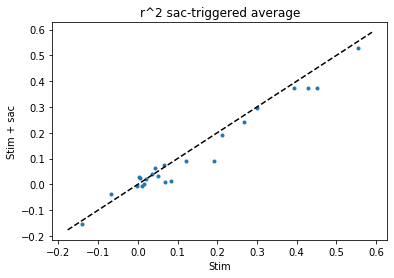

In [180]:
plt.plot(np.asarray(r2glm), np.asarray(r2sac), '.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')
plt.title('r^2 sac-triggered average')
plt.xlabel('Stim')
plt.ylabel('Stim + sac')